In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             precision_score, 
                             recall_score,
                             f1_score)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load the sample data 
#telco data and predict if customer will churn or not
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df["Churn"] = df["Churn"].apply(lambda x: 1 if x=="Yes" else 0)
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


-----

In [153]:
def lift_score(y_true, y_pred_prob, metadata=False):
    """
    Computes the lift scores per decile group.
    INPUT:
    y_true: <numpy.array(1-dim)>
            class labels containing 1 and 0
    y_pred_prob: <numpy.array(1-dim)>
                 probability predictions of the model
    """
    prob_df = pd.DataFrame([y_true, y_pred_prob],
                           index = ["y_true", "y_pred_prob"]).T
    prob_df["prob_rank"] = prob_df["y_pred_prob"].rank(method="first")
    prob_df["decile_group"] = pd.qcut(prob_df["prob_rank"].values, q=10,
                                     labels=["decile %s"%(str(i+1).zfill(2)) for i in range(0, 10)])
    per_decile = prob_df.groupby("decile_group")\
                        .apply(lambda x: pd.Series([len(x), 
                                                    x["y_true"].sum(),
                                                    x["y_pred_prob"].min(),
                                                    x["y_pred_prob"].max()],
                                                   index=["counts",
                                                          "num_engaged",
                                                          "min_prob",
                                                          "max_prob"]))\
                        .sort_index(ascending=False)
    per_decile["ave_response_rate"] = per_decile["num_engaged"]/per_decile["counts"]
    baseline_response_rate = y_true.mean()
    per_decile["lift_scores"] = per_decile["ave_response_rate"]/baseline_response_rate
    
    per_decile["cum_counts"] = per_decile["counts"].cumsum()
    per_decile["cum_num_engaged"] = per_decile["num_engaged"].cumsum()
    per_decile["cum_ave_response_rate"] = per_decile["cum_num_engaged"]/per_decile["cum_counts"]
    per_decile["percent_responders_reached"] = (per_decile["cum_num_engaged"]/(per_decile["num_engaged"].sum()))*100
    per_decile["percent_customers_contacted"] = (per_decile["cum_counts"]/(per_decile["counts"].sum()))*100
    
      
    return per_decile

MODELS = {"logreg": LogisticRegression(),
          "dectree": DecisionTreeClassifier(),
          "extree": ExtraTreeClassifier(),
          "ranfor": RandomForestClassifier(),
          "aboost": AdaBoostClassifier(),
          "gboost": GradientBoostingClassifier(),
          "dummy": DummyClassifier()}

MODELS_LABELS = {"logreg": "Logistic Regression",
                 "dectree": "Decision Tree Classifier",
                 "extree": "Extra Tree Classifier",
                 "ranfor": "Random Forest Classifier",
                 "aboost": "AdaBoost Classifier",
                 "gboost": "Gradient Boosting Classifier",
                 "dummy": "Dummy Classifier"}

METRICS = {"acc": accuracy_score,
           "prec": precision_score,
           "recall": recall_score,
           "f1": f1_score,
           "toplift": lift_score}

def show_lift_waterfall(y_test, per_decile):
    
    #waterfall chart of the response rates
    baseline_response_rate = y_test.mean()

    probs = per_decile["ave_response_rate"]*100
    problabel = \
        (per_decile["min_prob"].round(3).astype(str).str.ljust(5, "0") + " - " +\
         per_decile["max_prob"].round(3).astype(str).str.ljust(5, "0") + "\n" +\
         per_decile.index + "\n N = " +\
         per_decile["counts"].astype(int).astype(str) + "\nLift Score:" +\
         per_decile["lift_scores"].round(3).astype(str))

    fig0, ax0 = plt.subplots(figsize=(16, 5), nrows=1, ncols=1)
    fig0.tight_layout()
    
    ax0.bar(problabel, probs)
    ax0.set_ylabel("Response Rate (%)", size=14)
    ax0.set_xlabel("Decile Groups", size=14)
    ax0.axhline(baseline_response_rate*100, color="red", 
                label="baseline response rate({0:.2g}%)".format(baseline_response_rate*100))
    ax0.set_title("(Waterfall Plot)Response Rates per Decile Group", size=15)
    for i in range(len(problabel)):
        ax0.annotate(xy = (problabel[i], probs[i]+0.01), s="{0:.2g}%".format(probs[i]), ha="center")
    ax0.legend()

    return fig0, ax0

def show_lift_gains(y_test, per_decile):
    
    fig1, ax1 = plt.subplots(figsize=(16,5), nrows=1, ncols=2)
    fig1.tight_layout()

    #cumulative gains chart
    percent_customers_contacted = np.append(0, per_decile["percent_customers_contacted"].values)
    percent_responders_reached = np.append(0, per_decile["percent_responders_reached"].values)
    ax1[0].plot([0,100], [0,100], ls="--")
    ax1[0].plot(percent_customers_contacted, percent_responders_reached, marker="o")
    ax1[0].set_xlim((-5, 105))
    ax1[0].set_ylim((-5, 105))
    ax1[0].set_xlabel("(%) Customers Contacted", size=14)
    ax1[0].set_ylabel("(%) Responders Reached", size=14)
    ax1[0].set_title("Cumulative Gains Chart", size=15)
    ax1[0].set_xticks(np.arange(0, 101, 10))

    cum_counts = np.append('0', per_decile["cum_counts"].astype(int).astype(str).values)
    cum_num_engaged = np.append(0, per_decile["cum_num_engaged"].values)
    xticklabels = \
    pd.Series(np.arange(0, 101, 10).astype(str)) + "%\nN=" +\
    pd.Series(cum_counts)
    ax1[0].set_xticklabels(xticklabels, rotation=45)

    ax1[0].set_yticks(np.arange(0, 101, 10))
    for i in range(len(percent_customers_contacted)):
        ax1[0].annotate(xy = (percent_customers_contacted[i], percent_responders_reached[i]+0.01),
                        s="N=%d"%(cum_num_engaged[i]), ha="center")

    #lift chart
    lift_scores = np.append(np.nan, per_decile["lift_scores"].values)
    ax1[1].plot([0, 100], [1, 1], ls="--")
    ax1[1].plot(percent_customers_contacted, lift_scores, marker="o")
    ax1[1].set_ylabel("Lift Score", size=14)
    ax1[1].set_xlabel("(%) Customers Contacted", size=14)
    ax1[1].set_xticks(np.arange(0, 101, 10))
    ax1[1].set_xticklabels(xticklabels, rotation=45)
    ax1[1].set_title("Lift Chart", size=15)
    
    return fig1, ax1

class Dataset(object):
    def __init__(self, data, target, rowid):
        
        #data - <pandas.DataFrame> 
        #target - <string> column name for target variable, should be binary
        #rowid - <string> column name for row identification
        
        self.data = data
        self.target = target
        self.rowid = rowid
        
        #check if target is binary
        if self.data[target].nunique() != 2 and \
           self.data[target].unique() != np.arange(2):
            raise ValueError("Target variable should be binary")
            
        
        self.dtype = self.infer_col_dtype()
        self.feat_cols = self.data.columns.drop([target, rowid])
        self.feat_data, self.label_binarizers = self.process_data()
        
        #check for null values in feat_data
        #for now, drop any rows containing null values in self.feat_data
        self.drop_index = self.feat_data[self.feat_data.isnull().any(axis=1)].index
        self.feat_data = self.feat_data.drop(self.drop_index)
        self.data = self.data.drop(self.drop_index)
        
    def infer_col_dtype(self, thresh=0.01):
        #infer if column is continuous or categorical
        #all columns at first will treated as ctegorical
        #will evaluate if each qualify to be continuous
        
        #thresh - threshold to use, on how varied the column values are
        
        dtype = {}
        for col in self.data.columns:
            unique_val = self.data[col].unique()
            #1. should be varied
            varied = 1.*len(unique_val)/self.data[col].count() > thresh
            
            #2. should be convertible to numeric
            try:
                pd.to_numeric(self.data[col].astype(str).str.strip())
                numeric = True
            except ValueError:
                numeric = False
                
            #3. does not start with 0
            no_trail_0 = \
            ~(self.data[col].astype(str).str.strip()\
                            .str.startswith("0")).all()
            
            if varied and numeric and no_trail_0:
                dtype[col] = "continuous"
            else:
                dtype[col] = "categorical" 
        return dtype
    
    def process_data(self):
        #will prepare the dataset to be used for training of models
        #for conitnuous variables, retain them
        #for categorical variables, transform it to OHE features
        
        feat_data = pd.DataFrame()
        label_binarizers = {}
        for feat in self.feat_cols:
            colval = self.data[feat]
            if self.dtype[feat]=="continuous":
                colval = pd.to_numeric(colval.astype(str).str.strip())
                feat_data = pd.concat([feat_data, colval], 
                                         axis=1)
            else: #categorical variables
                lb = LabelBinarizer()
                colval = lb.fit_transform(colval)
                lb.classes_ = lb.classes_.astype(str)
                if len(lb.classes_) > 2:
                    colnames = [feat+"_"+"".join(i.split()) for i in lb.classes_]
                else:
                    colnames = [feat+"_"+"".join(lb.classes_[-1].split())]
                colval = pd.DataFrame(colval, columns=colnames)
                feat_data = pd.concat([feat_data, colval], axis=1)
                label_binarizers[feat] = lb
        return feat_data, label_binarizers
        
        
        
        

class PropensityModel(object):
    def __init__(self, dataset, metric="toplift"):
        #dataset - Dataset class instance
        self.dataset = dataset
        self.metric = metric
        self.rowid = self.dataset.data[self.dataset.rowid]\
                         .reset_index(drop=True)
        self.X = self.dataset.feat_data\
                     .reset_index(drop=True)
        self.y = self.dataset.data[self.dataset.target]\
                     .reset_index(drop=True)
        
        #train propensity model
        self.train_test_split()
        self.train_prop_models()
        
    def train_test_split(self, test_size=0.3):
        (self.train_ind, self.test_ind) = \
            train_test_split(self.rowid.index, test_size=test_size)
        
        #train set
        self.X_train, self.y_train, self.rowid_train = \
            (self.X.loc[self.train_ind], 
             self.y.loc[self.train_ind],
             self.rowid.loc[self.train_ind])
        
        #test set
        self.X_test, self.y_test, self.rowid_test = \
            (self.X.loc[self.test_ind], 
             self.y.loc[self.test_ind],
             self.rowid.loc[self.test_ind])
        
    def train_prop_models(self):
        
        self.models = {}
        self.best_model = None
        self.best_score = 0 #start with 0
        self.train_metrics = {}
        self.test_metrics = {}
        
        if self.metric=="toplift":
            self._train_lift_scores = {}
            self._test_lift_scores = {}
        
        for mod in MODELS:
            model = MODELS[mod]
            model.fit(self.X_train.values, self.y_train.values)
            self.models[mod] = model
            
            y_train_preds = model.predict(self.X_train.values)
            y_test_preds = model.predict(self.X_test.values)
            
            y_train_pred_probs = model.predict_proba(self.X_train.values)[:,1]
            y_test_pred_probs = model.predict_proba(self.X_test.values)[:,1]
            
            #evaluate the model
            train_metrics = {}
            test_metrics = {}
            for met in METRICS:
                metric_func = METRICS[met]
                
                if met=="toplift":
                    #get the top decile's lift score
                    self._train_lift_scores[mod] = metric_func(self.y_train.values, y_train_pred_probs)
                    self._test_lift_scores[mod] = metric_func(self.y_test.values, y_test_pred_probs)
                    train_metrics[met] = self._train_lift_scores[mod]["lift_scores"].iloc[0]
                    test_metrics[met] = self._test_lift_scores[mod]["lift_scores"].iloc[0]
                else:
                    train_metrics[met] = metric_func(self.y_train.values, y_train_preds)
                    test_metrics[met] = metric_func(self.y_test.values, y_test_preds)
            self.train_metrics[mod] = train_metrics
            self.test_metrics[mod] = test_metrics
            
            if test_metrics[self.metric] > self.best_score:
                self.best_model = {mod:model}
                self.best_score = test_metrics[self.metric]
                
        self.train_metrics = pd.DataFrame(self.train_metrics)
        self.test_metrics = pd.DataFrame(self.test_metrics)   
        
    def show_lift_analysis(self, all_models="best", show_chart=False):
        #models: "best" or True
        #show_lift_gains: <boolean>
        if len(self._test_lift_scores)==0:
            raise ValueError("No trained models stored.")
        
        if all_models==True:
            for mod in self._test_lift_scores:
                model_label = MODELS_LABELS[mod]
                fig0, ax0 = show_lift_waterfall(self.y_test, self._test_lift_scores[mod])
                ax0.set_title(ax0.get_title()+"\n(Model: %s)"%model_label,
                          size=ax0.title.get_size())
                if show_chart:
                    fig1, ax1 = show_lift_gains(self.y_test, self._test_lift_scores[mod])
                    for ax in ax1:
                        ax.set_title(ax.get_title()+"\n(Model: %s)"%model_label,
                                     size=ax.title.get_size())
            
        elif all_models=="best":
            best_model = self.best_model.keys()[0]
            model_label = MODELS_LABELS[best_model]
            fig0, ax0  = show_lift_waterfall(self.y_test, self._test_lift_scores[best_model])
            ax0.set_title(ax0.get_title()+"\n(Model: %s)"%model_label,
                          size=ax0.title.get_size())
            if show_chart:
                fig1, ax1  = show_lift_gains(self.y_test, self._test_lift_scores[best_model])
                for ax in ax1:
                    ax.set_title(ax.get_title()+"\n(Model: %s)"%model_label,
                                 size=ax.title.get_size())
            

In [154]:
dataset = Dataset(df, "Churn", "customerID")
propmodel = PropensityModel(dataset, "toplift")

In [156]:
propmodel.best_model

{'aboost': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None)}

In [157]:
propmodel.train_metrics

,aboost,dectree,dummy,extree,gboost,logreg,ranfor
acc,0.816132,0.997359,0.605039,0.997359,0.838480,0.813694,0.978870
f1,0.609746,0.994924,0.241810,0.994924,0.651469,0.610616,0.958333
prec,0.684414,0.999216,0.242567,0.999216,0.746734,0.672591,0.988430
recall,0.549767,0.990669,0.241058,0.990669,0.577760,0.559098,0.930016
toplift,3.035502,3.827372,0.954902,3.827372,3.206297,2.950104,3.827372


In [158]:
propmodel.test_metrics

,aboost,dectree,dummy,extree,gboost,logreg,ranfor
acc,0.789100,0.730332,0.591943,0.725592,0.800948,0.792891,0.769668
f1,0.574163,0.504787,0.253252,0.492550,0.593810,0.588124,0.507099
prec,0.649351,0.512367,0.256140,0.503584,0.680710,0.652720,0.620347
recall,0.514580,0.497427,0.250429,0.481990,0.526587,0.535163,0.428816
toplift,2.898799,1.732419,0.806175,1.680961,2.778731,2.744425,2.504288


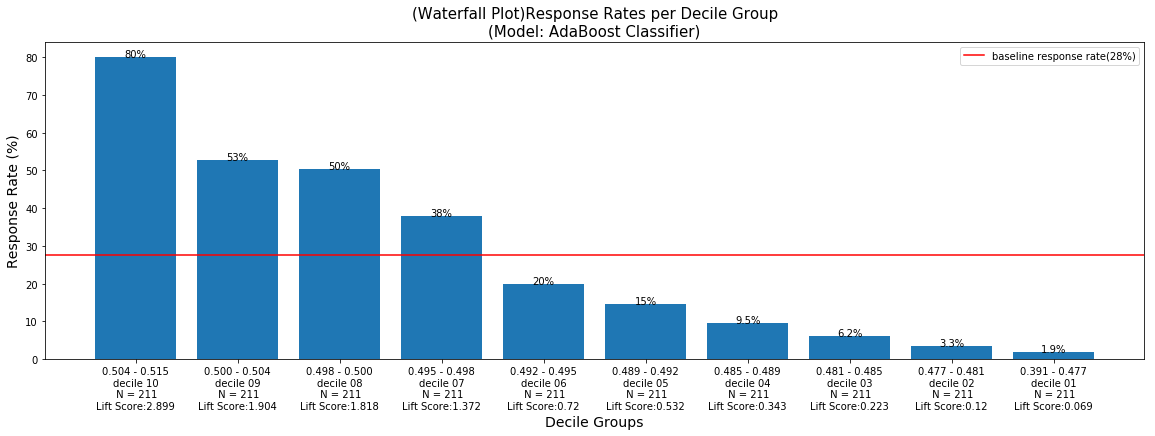

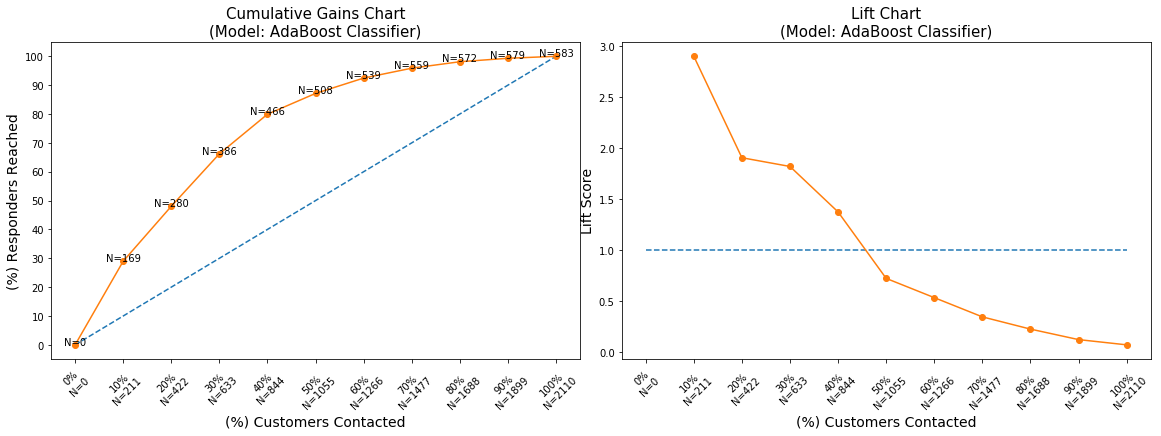

In [160]:
propmodel.show_lift_analysis(all_models="best", show_chart=True)